In [21]:
# Boilerplate at top of file
%load_ext autoreload

%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
from ggplot import *


### Custom
import nltk
import sys
sys.path.append('../')
import cleaner
from feature_eng import FeatureFactory
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor

from sklearn.linear_model import LinearRegression,  Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.pipeline import Pipeline

In [43]:
ff = FeatureFactory(corpus_csv='../data/product_descriptions.csv', pickle_path = '../pickles/')

Loading science data for  SearchDescriptionCountVectorizer  from  ../pickles//SearchDescriptionCountVectorizer.pkl
Generating a corpus index
Loading science data for  SearchDescriptionTfidfVectorizer  from  ../pickles//SearchDescriptionTfidfVectorizer.pkl
Generating a corpus index


In [124]:
df_train_full = pd.read_csv('../data/train_features_v2.csv')
# smaller ssample size for test_purposes
df_train = df_train_full

In [144]:
df_train = df_train.iloc[random.sample(df_train.index,2000)].reset_index()

In [126]:
## Constants
Y_KEY = 'relevance'
feat_cols = ff.get_feature_names()

In [187]:
def apse_k_fold(clfs, x, y, k = 10, 
                m_metric = lambda x,y : mean_squared_error(x,y)**0.5,
                verbose=False,
               feature_selection = lambda df, x_col, y_col: (np.array(df[x_col]), np.array(df[y_col]))
               ):
    # all uses the same folds
    # for RMSE
    n = len(y)

    X = np.array(x)
    y = np.array(y)

    print X.shape
    kf = KFold(n, n_folds=k)

#     X = np.array(df[x_col])
#     y = np.array(df[y_col])
    results = []
    for clf in clfs:
        if verbose:
            print '%s-Fold Cross Validation for %s' % (k, clf.__class__.__name__)
        fm = clone(clf).fit(X, y)
        apses = []
        varias =  []
        for train_index, test_index in kf:
        #     print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            fm_y_pred = fm.predict(X_test)
            var = m_metric(y_test, fm_y_pred)
            apse = m_metric(y_test, y_pred)
            apses.append(apse)
            varias.append(var)
#             mse = m_metric(fm_y_pred, y_)
            if verbose:
                print "APSE", apse, "Variance", var
        results.append(dict(
            classifier = clf.__class__.__name__,
            params = clf.get_params(),
            apse_mean = np.mean(apses),
            var_mean = np.mean(varias),
            ))
    return pd.DataFrame(results)
from sklearn.feature_selection import f_regression
def feature_selection(df, x_col, y_col):
    kbest = SelectKBest(f_regression, k=5)
    X =  kbest.fit_transform(df[x_col], df[y_col])
    Y = df[y_col]
    return X,Y

In [190]:
rf = RandomForestRegressor()
lm = LinearRegression()
lasso = LassoCV()
gbr = GradientBoostingRegressor()
bgr = BaggingRegressor()
knn = KNeighborsRegressor()
# apse_k_fold(rf, df_train, feat_cols, Y_KEY)

df_res = apse_k_fold([rf, lm, lasso, gbr, bgr, knn], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)
df_res

(2000, 24)


,apse_mean,classifier,params,var_mean
0,0.528140,RandomForestRegressor,"{u'warm_start': False, u'oob_score': False, u'...",0.223918
1,0.504683,LinearRegression,"{u'copy_X': True, u'normalize': False, u'n_job...",0.499457
2,0.510403,LassoCV,"{u'normalize': False, u'alphas': None, u'n_job...",0.506328
3,0.501898,GradientBoostingRegressor,"{u'warm_start': False, u'loss': u'ls', u'verbo...",0.443130
4,0.536694,BaggingRegressor,"{u'max_samples': 1.0, u'base_estimator': None,...",0.228218
5,0.573118,KNeighborsRegressor,"{u'n_neighbors': 5, u'algorithm': u'auto', u'm...",0.462247


# visualize

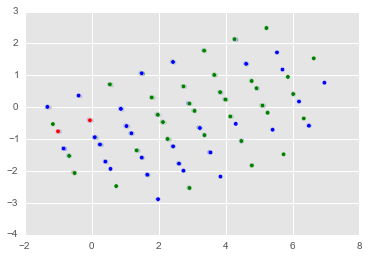

In [140]:
from sklearn.lda import LDA
from sklearn.decomposition import TruncatedSVD,PCA

lda = LDA()
svd = TruncatedSVD(n_components=2)
pca = PCA(n_components=2)
X, Y = feature_selection(df_train, feat_cols, Y_KEY)
Y = np.round(Y) - 1
X = pca.fit_transform(X,Y)

colors=['red', 'blue', 'green']
plt.scatter(X[:,0], X[:,1], c = map(lambda x: colors[int(x)], Y))

(2000, 24)


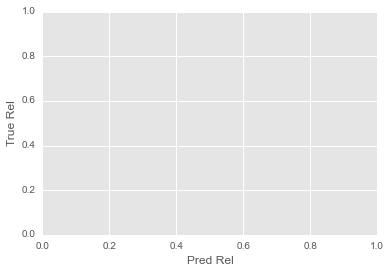

In [191]:
steps = [('var_thresh', VarianceThreshold()),
        ('kbest', SelectKBest(f_regression,k=22)),
        ('clf', GradientBoostingRegressor(max_features=22, max_depth=10,n_estimators=1000))]
pipeline = Pipeline(steps)
apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)
